# Neural Network From Scratch for Image Classification

****

# Imports

In [2]:
import sys
import pyspark
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix


print("Pyspark Script:", sys.argv[0])
print("PySpark version:", pyspark.__version__)

Pyspark Script: /Users/martinmarvin/.pyenv/versions/venv-3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py
PySpark version: 3.0.1


# Download MNIST Dataset from Keras

In [3]:
from keras.datasets import mnist, fashion_mnist
from keras.utils import np_utils

# load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() # For more fancy data use this

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)


np.savetxt('data/mnist_images_train.csv', x_train.reshape(len(x_train),784).tolist())
np.savetxt('data/mnist_images_test.csv', x_test.reshape(len(x_test),784).tolist())
np.savetxt('data/mnist_labels_train.csv', y_train.tolist())
np.savetxt('data/mnist_labels_test.csv', y_test.tolist())

# Load data

In [4]:
txt_train_images = sc.textFile("data/mnist_images_train.csv", 1)
x_train = txt_train_images.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 784)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_train_labels = sc.textFile("data/mnist_labels_train.csv", 1)
y_train = txt_train_labels.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 10)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_test_images = sc.textFile("data/mnist_images_test.csv", 1)
x_test = txt_test_images.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 784)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_test_labels = sc.textFile("data/mnist_labels_test.csv", 1)
y_test = txt_test_labels.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 10)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

In [5]:
train_rdd = x_train.join(y_train).map(lambda x: x[1])
test_rdd = x_test.join(y_test).map(lambda x: x[1])
train_rdd.cache()

print(train_rdd.take(1))

[(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

# Functions

## Activation Function

In [6]:
# General function to apply any activation function
def activation(x, f):
    return f(x)

# Sigmoid Activation function
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

# Sigmoid prime function (used for backward prop)
def sigmoid_prime(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

# Hyperbolic Tangent Activation function
def tanh(x):
    return np.tanh(x);

# Hyperbolic Tangent prime function (used for backward prop)
def tanh_prime(x):
    return 1-np.tanh(x)**2

## Forward Propagation

In [7]:
# Compute the layer propagation before activation
def preforward(x, w, b):
    return np.dot(x, w) + b

# Compute the layer propagation after activation
# This is also equivalent to a predict function once model is trained
def predict(x, W1, B1, W2, B2):
    return sigmoid(preforward(sigmoid(preforward(x , W1, B1)), W2, B2))

## Backward Propagation

In [8]:
# Compute the derivative of the error regarding B2
def derivativeB2(y_pred, y_true, y_h, f_prime):
    return (y_pred - y_true) * f_prime(y_h)

# Compute the derivative of the error regarding W2
def derivativeW2(h, dB2):
    return np.dot(h.T, dB2)

# Compute the derivative of the error regarding B1
def derivativeB1(h_h, dB2, W2, f_prime):
    return np.dot(dB2, W2.T) * f_prime(h_h)

# Compute the derivative of the error regarding W1
def derivativeW1(x, dB1):
    return np.dot(x.T, dB1)

## Evaluation

In [9]:
def get_metrics(pred, true):
    cm = multilabel_confusion_matrix(true, pred)
    return (cm)

# Cost function
def sse(y_pred, y_true):
    return 0.5 * np.sum(np.power(y_pred - y_true, 2))

# Training (Mini Batch Implementation)

Start Training Loop:
   Epoch 1/100 | Cost: 1.392479825485013 | Acc: 13.712693232975251 | Batchsize:41983
   Epoch 2/100 | Cost: 1.2709083195445854 | Acc: 14.169982606209345 | Batchsize:41969
   Epoch 3/100 | Cost: 1.1598964823231612 | Acc: 14.212642447600695 | Batchsize:42033
   Epoch 4/100 | Cost: 1.0527711636080355 | Acc: 14.689696247766529 | Batchsize:41975
   Epoch 5/100 | Cost: 0.9579163912914371 | Acc: 15.033177158893618 | Batchsize:42047
   Epoch 6/100 | Cost: 0.8751789122845879 | Acc: 15.423016290068315 | Batchsize:41866
   Epoch 7/100 | Cost: 0.8042386120910752 | Acc: 15.561248695322135 | Batchsize:42156
   Epoch 8/100 | Cost: 0.7427982740058269 | Acc: 16.137169510482856 | Batchsize:42021
   Epoch 9/100 | Cost: 0.6935086326648642 | Acc: 16.52598950882213 | Batchsize:41940
   Epoch 10/100 | Cost: 0.6512268274366569 | Acc: 16.979603507434234 | Batchsize:41968
   Epoch 11/100 | Cost: 0.6181664660304229 | Acc: 17.494095418044402 | Batchsize:42340
   Epoch 12/100 | Cost: 0.5903162

   Epoch 96/100 | Cost: 0.14892911589274416 | Acc: 83.18267464879433 | Batchsize:41927
   Epoch 97/100 | Cost: 0.14674058805977502 | Acc: 83.45868229376735 | Batchsize:42149
   Epoch 98/100 | Cost: 0.14583249171843085 | Acc: 83.52737122220111 | Batchsize:42088
   Epoch 99/100 | Cost: 0.1430689268833265 | Acc: 83.93187972067835 | Batchsize:42102
   Epoch 100/100 | Cost: 0.1409441712676419 | Acc: 84.25936942296252 | Batchsize:42025
Training end..


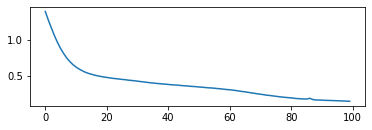

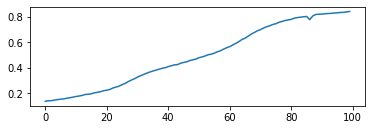

In [10]:
# Hyperparameters
num_iteration = 100
learningRate = 0.1

input_layer = 784 # number of neurones in the input layer (equal to image size)
hidden_layer = 64 # number of neurones in the hidden layer (Custom)
output_layer = 10 # number of neurones in the output layer (equal to the number of possible labels)


# Paramater Initialization
W1 = np.random.rand(input_layer, hidden_layer) - 0.5 # Shape (784, 64)
W2 = np.random.rand(hidden_layer, output_layer) - 0.5 # Shape (64, 10)
B1 = np.random.rand(1, hidden_layer) - 0.5 # Shape (1, 64)
B2 = np.random.rand(1, output_layer) - 0.5 # Shape (1, 10)

# History over epochs
cost_history = []
acc_history = []

# Epoch Loop (mini batch implementation)
print("Start Training Loop:")

for i in range(num_iteration):
    
    # Compute gradients, cost and accuracy over mini batch 
    
    ################## Notations ######################
    # x -> Input Image flatten of shape (1, 784)
    # y* -> One hot label of shape (1, 10)
    # h^ -> Forward prop from Input layer to hidden layer before activation (1, 64) using W1, B1 parm
    # h -> Forward prop from Input layer to hidden layer after tanh activation (1, 64)
    # y^ -> Forward prop from hidden layer to output layer before activation (1, 10) using W2, B2 parm
    # y -> Forward prop from hidden layer to output layer after sigmoid activation (1, 10)
    # E -> Error between y and y* using SSE
    # Acc -> 1 is right prediction 0 otherwise
    # DE/D? -> Partial derivative of the Error regarding parmaters (B2, W2, B1, W1)
    
    
    ################# Forward Prop ######################
    # map batch ([x], [y*]) to ([x], [h^],[y*])
    # map batch ([x], [h^],[y*]) to ([x], [h^], [h], [y*])
    # map batch ([x], [h^], [h], [y*]) to ([x], [h^], [h], [y^], [y*])
    # map batch ([x], [h^], [h], [y^], [y*]) to ([x], [h^], [h], [y^], [y], [y*])
    ################# Backward Prop #####################
    # map batch ([x], [h^], [h], [y^], [y], [y*]) to ([x], [h^], [h], [E], [DE/DB2], [Acc])
    # map batch ([x], [h^], [h], [E], [DE/DB2], [Acc]) to ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc])
    # map batch ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc]) to ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc])
    # map batch ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc]) to ([E], [DE/DB2], [DE/DW2], [DE/DB1], [DE/DW1],[Acc])
    ############### Reduce over the mini batch #########


    gradientCostAcc = train_rdd\
                        .sample(False,0.7)\
                        .map(lambda x: (x[0], preforward(x[0], W1, B1), x[1]))\
                        .map(lambda x: (x[0], x[1], activation(x[1], tanh), x[2]))\
                        .map(lambda x: (x[0], x[1], x[2], preforward(x[2], W2, B2), x[3]))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], activation(x[3], sigmoid), x[4]))\
                        .map(lambda x: (x[0], x[1], x[2], sse(x[4], x[5]), derivativeB2(x[4], x[5], x[3], sigmoid_prime), int(np.argmax(x[4]) == np.argmax(x[5]))))\
                        .map(lambda x: (x[0], x[1], x[3], x[4],  derivativeW2(x[2], x[4]) ,x[5]))\
                        .map(lambda x: (x[0], x[2], x[3], x[4],  derivativeB1(x[1],  x[3], W2, tanh_prime) ,x[5]))\
                        .map(lambda x: (x[1], x[2], x[3], x[4], derivativeW1(x[0], x[4]) ,x[5], 1)) \
                        .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3], x[4] + y[4], x[5] + y[5], x[6] + y[6]))

    # Cost and Accuarcy of the mini batch
    n = gradientCostAcc[-1] # number of images in the mini batch
    cost = gradientCostAcc[0]/n # Cost over the mini batch
    acc = gradientCostAcc[5]/n # Accuarcy over the mini batch
    
     # Add to history
    cost_history.append(cost)
    acc_history.append(acc)
    
    # Bold Driver technique to dynamically change the learning rate
    if len(cost_history) > 1:
        if cost_history[i] < cost_history[i-1]:
            learningRate *= 1.05 #Better than last time
        else:
            learningRate *= 0.5 #Worse than last time
    
    # Extract gradiends
    DB2 = gradientCostAcc[1]/n
    DW2 = gradientCostAcc[2]/n
    DB1 = gradientCostAcc[3]/n
    DW1 = gradientCostAcc[4]/n
            
    # Update parameter with new learning rate and gradients using Gradient Descent
    B2 -= learningRate * DB2
    W2 -= learningRate * DW2
    B1 -= learningRate * DB1
    W1 -= learningRate * DW1

    # Display performances
    print(f"   Epoch {i+1}/{num_iteration} | Cost: {cost_history[i]} | Acc: {acc_history[i]*100} | Batchsize:{n}")

print("Training end..")

# Plot of cost over epochs
plt.subplot(2, 1, 1)
plt.plot(cost_history)
plt.show()

# Plot of accuracy over epochs
plt.subplot(2, 1, 2)
plt.plot(acc_history)
plt.show()

# Test Evaluation

In [11]:
# Use the trained model over the Testset and get Confusion matrix per class
metrics = test_rdd.map(lambda x: get_metrics(np.round(predict(x[0], W1, B1, W2, B2)), x[1]))\
                  .reduce(lambda x, y: x + y)

# For each class give TP, FP, FN, TN and precision, and recall, and F1 score
for label, label_metrics in enumerate(metrics):
    
    print(f"\n---- Digit {label} ------\n")
    tn, fp, fn, tp = label_metrics.ravel()
    print("TP:", tp, "FP:", fp, "FN:", fn, "TN:", tn)

    precision = tp / (tp + fp + 0.000001)
    print(f"\nPrecision : {precision}")

    recall = tp / (tp + fn + 0.000001)
    print(f"Recall: {recall}")

    F1 = 2 * (precision * recall) / (precision + recall + 0.000001)
    print(f"F1 score: {F1}")


---- Digit 0 ------

TP: 962 FP: 531 FN: 18 TN: 8489

Precision : 0.6443402540895242
Recall: 0.9816326520595585
F1 score: 0.7780019470898399

---- Digit 1 ------

TP: 1011 FP: 12 FN: 124 TN: 8853

Precision : 0.988269793755357
Recall: 0.8907488978936132
F1 score: 0.9369781844453244

---- Digit 2 ------

TP: 577 FP: 11 FN: 455 TN: 8957

Precision : 0.9812925153379379
Recall: 0.5591085265900111
F1 score: 0.7123452156915058

---- Digit 3 ------

TP: 754 FP: 102 FN: 256 TN: 8888

Precision : 0.8808411204663071
Recall: 0.7465346527262033
F1 score: 0.8081452688848058

---- Digit 4 ------

TP: 915 FP: 661 FN: 67 TN: 8357

Precision : 0.5805837559767869
Recall: 0.9317718931448351
F1 score: 0.7154021847291463

---- Digit 5 ------

TP: 15 FP: 0 FN: 877 TN: 9108

Precision : 0.9999999333333378
Recall: 0.016816143478905667
F1 score: 0.03307604237046982

---- Digit 6 ------

TP: 875 FP: 246 FN: 83 TN: 8796

Precision : 0.7805530769129767
Recall: 0.9133611681488923
F1 score: 0.8417503440148915

---

pred: 3, prob: 0.34 true: 8


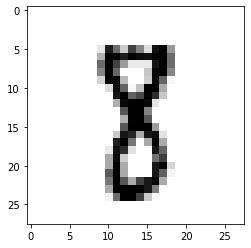

pred: 4, prob: 0.73 true: 4


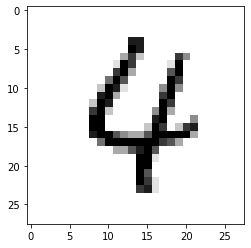

pred: 6, prob: 0.93 true: 6


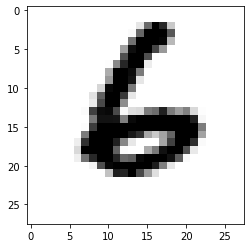

pred: 4, prob: 0.76 true: 4


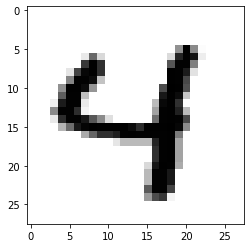

pred: 0, prob: 0.92 true: 0


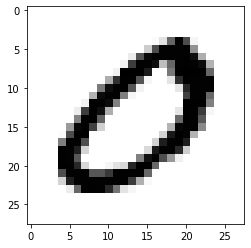

pred: 7, prob: 0.36 true: 5


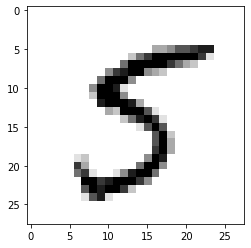

pred: 1, prob: 0.68 true: 1


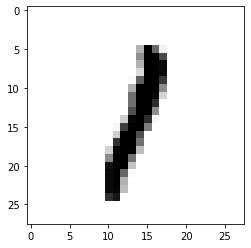

pred: 4, prob: 0.79 true: 4


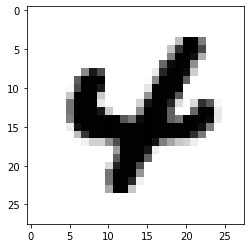

pred: 4, prob: 0.87 true: 4


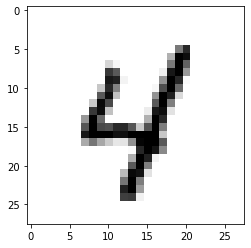

pred: 8, prob: 0.24 true: 8


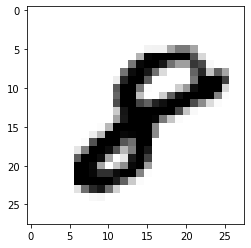

pred: 1, prob: 0.75 true: 1


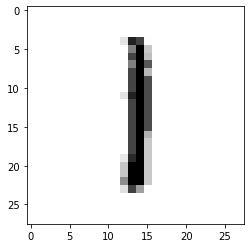

pred: 6, prob: 0.88 true: 6


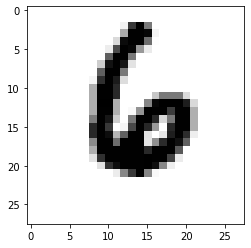

pred: 6, prob: 0.39 true: 8


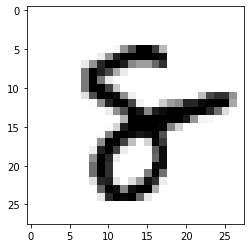

pred: 3, prob: 0.46 true: 9


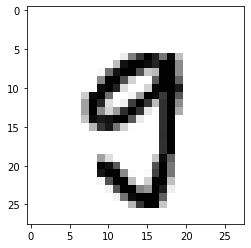

pred: 4, prob: 0.52 true: 9


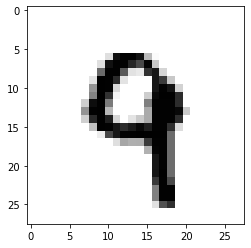

In [12]:
# Display some Images for checking
for image_test in test_rdd.map(lambda x: (x[0], predict(x[0], W1, B1, W2, B2), np.argmax(x[1]))).takeSample(False, 15):
    
    pred = np.argmax(image_test[1])
    print(f'pred: {pred}, prob: {round(image_test[1][0][pred], 2)} true: {image_test[2]}')
    image = np.reshape(image_test[0], (28, 28))
    plt.imshow(image, cmap='binary')
    plt.show()

# Thank you !